# Warsztaty Badawcze

### Anna Kozioł
### Andzelika Zalewska

Projekt dotyczy analizy rzeczywistego szeregu sprzedażay (2005-2007) pewnego produktu z rynku farmaceutycznego. Naszym zadaniem jest dopasowanie adekwatnego modelu ARIMA, a następnie przeprowadzenie wnioskowania przybliżonego w oparciu o model rozmyty typu Mamdani i dokonanie agregacji prognoz uzyskanych z dopasowanego modelu ARIMA oraz prognoz rynkowych.

In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import statsmodels
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import re
import matplotlib
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [4]:
def approximate_reasoning_for_forecasts(df,ekspert,litera='J'):
    import matplotlib
    import matplotlib.pyplot as plt
    indeks = df[df[0]==litera].index.values.astype(int)[0]
    ts = df.iloc[indeks,1:]
    ts = Series(ts.astype(np.float))
    #ts = df[df[0] == litera].loc[:,'1':'42'].T
    daty = pd.date_range('2005-01', '2008-01', freq='M')
    #ts = Series(ts.astype(np.float))
    model = pm.auto_arima(ts, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    print(model.summary())

    model.plot_diagnostics(figsize=(7,5))
    plt.show()
    p = list(model.get_params().values())[2][0]
    d = list(model.get_params().values())[2][1]
    q = list(model.get_params().values())[2][2]
    print('Wybrane parametry:', 'p:', p,'d:', d,'q:', q)
    
    ts_np = np.array(ts)
    model = ARIMA(ts_np, order=(p,d,q))
    model_fit = model.fit(disp=0)
    model_fit.forecast()
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    pred = model_fit.predict()
    pred = pd.DataFrame(pred)
    pred.plot()
    ts_diff = ts.diff(periods=d).dropna()
    plt.plot(ts_diff, color='red')
    plt.show()
    # prognoza na 6 miesiecy
    pred_6msc = model_fit.forecast(6)[0]
    np.savetxt("prognozy_6miesiecy.csv", pred_6msc, delimiter=",")
    
    
    #def uniwersum i zmnienne lingwistyczne
    a = ts.copy()
    max_for_universe=np.max(a)
    universe = np.arange(0, max_for_universe, 1)
    names_3 = ['low', 'medium', 'high']
    fcst_arma = ctrl.Antecedent(universe, 'fcst_arma')
    fcst_expert = ctrl.Antecedent(universe, 'fcst_expert')
    fcst_final = ctrl.Consequent(universe, 'fcst_final')

    fcst_arma['low'] = fuzz.trapmf(fcst_arma.universe, [0, 0, 10000, 20000])
    fcst_arma['medium'] = fuzz.trapmf(fcst_arma.universe, [15000, 25000, 40000, 55000])
    fcst_arma['high'] = fuzz.trapmf(fcst_arma.universe, [40000, 50000 , 100000, 100000])

    fcst_expert['low'] = fuzz.trapmf(fcst_expert.universe, [0, 0, 10000, 20000])
    fcst_expert['medium'] = fuzz.trapmf(fcst_expert.universe, [15000, 25000, 40000, 55000])
    fcst_expert['high'] = fuzz.trapmf(fcst_expert.universe, [40000, 50000 , 100000, 100000])

    fcst_final['low'] = fuzz.trapmf(fcst_final.universe, [0, 0, 10000, 20000])
    fcst_final['medium'] = fuzz.trapmf(fcst_final.universe, [15000, 25000, 40000, 55000])
    fcst_final['high'] = fuzz.trapmf(fcst_final.universe, [40000, 50000 , 100000, 100000])
    fcst_arma['medium'].view()
    
    rule1 = ctrl.Rule(fcst_arma['high'] | fcst_expert['high'], fcst_final['high'])
    rule2 = ctrl.Rule(fcst_arma['low'], fcst_final['low'])
    rule3 = ctrl.Rule(fcst_arma['medium'] | fcst_expert['medium'], fcst_final['medium'])

    final_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

    final = ctrl.ControlSystemSimulation(final_ctrl)
    
    
   
    
    #wczytujemy wiedze ekspertow
    df = pd.read_csv("prognozy.csv", header = None, sep = ";")
    ts_prog = ekspert[ekspert[0] == litera].loc[:,'1':'42'].T
    ts_pd_prog = ts
    ts_np_prog = np.array(ts)
    
    #ostateczna ramka 
    arma_p = []
    ekspert = []
    ostatecznie = []
    for i in range(len(pred_6msc)):
        final.input['fcst_arma'] = pred_6msc[i]
        arma_p.append(pred_6msc[i])
        final.input['fcst_expert'] = ts_np_prog[i]
        ekspert.append(ts_np_prog[i])
        final.compute()
        ostatecznie.append(final.output['fcst_final'])
        
        
    print('współrzędna x środka ciężkości:',final.output['fcst_final'])

    ts_result = pd.DataFrame({
        'arma_p': arma_p,
        'ekspert': ekspert,
        'ostatecznie': ostatecznie
    })
    ts_result.to_csv("Wyniki.csv")
    
    
    return ts_result
    

In [5]:
ekspert = pd.read_csv("prognozy.csv", header = None, sep = ";")
df = pd.read_csv("dane_projekt.csv", header = None, sep = ";")

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=946.172, BIC=953.026, Time=0.058 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=978.348, BIC=981.775, Time=0.005 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=965.232, BIC=970.372, Time=0.006 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=945.485, BIC=950.626, Time=0.082 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=976.360, BIC=978.074, Time=0.004 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=944.765, BIC=953.333, Time=0.037 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=946.861, BIC=953.715, Time=0.027 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=946.650, BIC=956.932, Time=0.057 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0,

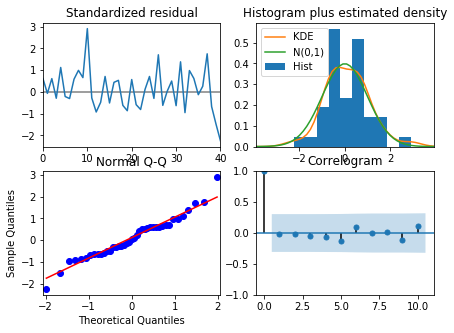

Wybrane parametry: p: 2 d: 1 q: 1


C:\Users\Ania\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Ania\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Ania\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Ania\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Ania\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available'

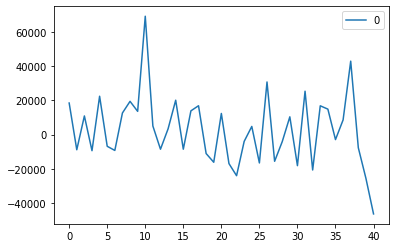

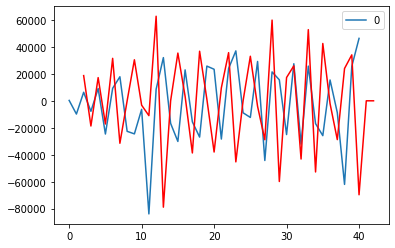

C:\Users\Ania\Anaconda3\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


współrzędna x środka ciężkości: 33939.39393939339


,arma_p,ekspert,ostatecznie
0,46796.145683,0.0,49942.119477
1,28608.642294,18696.0,33939.393939
2,22298.979676,0.0,34177.494112
3,30755.349784,17200.0,33939.393939
4,29756.192146,0.0,33939.393939
5,28097.130679,31500.0,33939.393939


C:\Users\Ania\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Ania\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


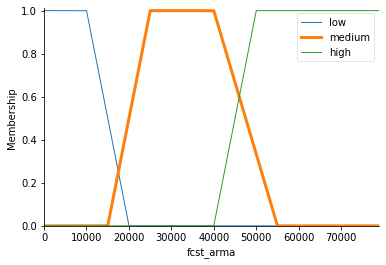

In [6]:
approximate_reasoning_for_forecasts(df, ekspert, 'J')